**SMS SPAM/HAM DATASET**
==============
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

Analysing the dataset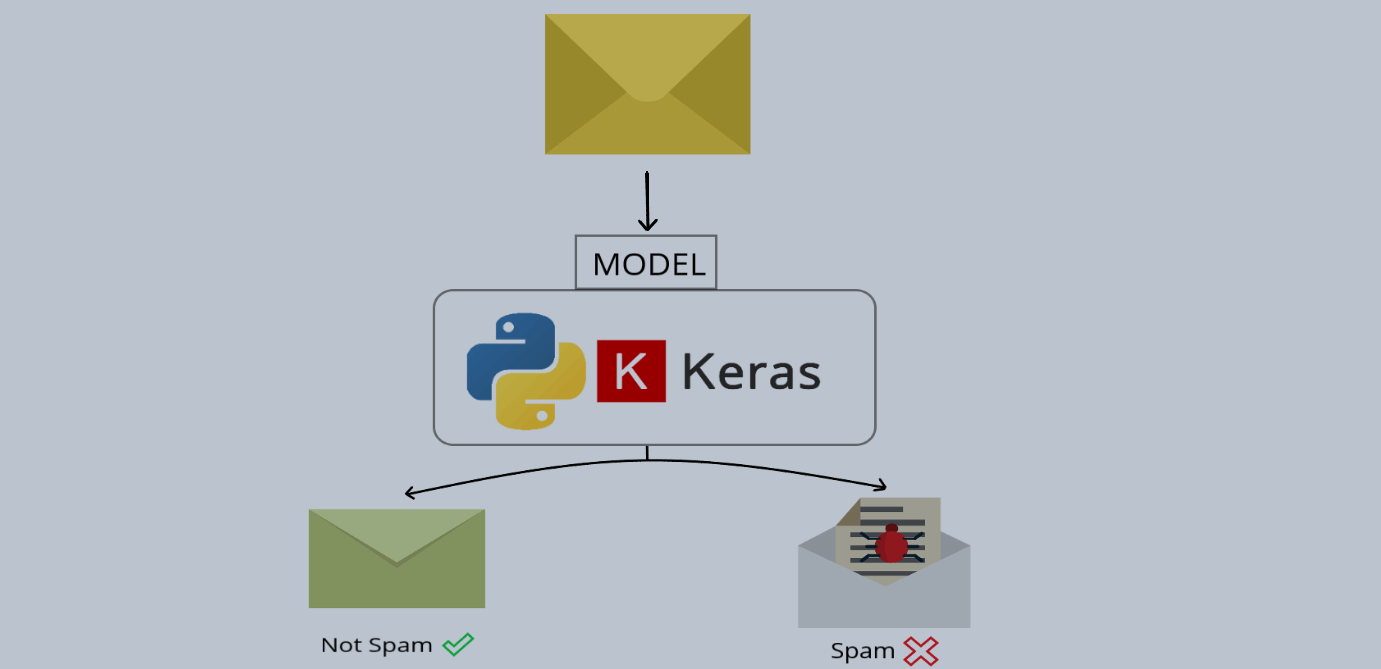
------

Objective is to predict if a new sms is spam or ham.It is much worse to misclassify ham than misclassify an spam.

*The reason is we normally don't check the spam messages if a ham message is moved to spam folder we probably don't read it.*
The two possible situations are:
------------

* New spam sms in my inbox. (False negative). I delete it.
* New ham sms in my spam folder (False positive). I may not read it.

I prefer the first case and I dont want False positives.

First we transform the variable spam/ham into binary variable, then we split our data set in training set and test .



In [93]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string


In [94]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords.words('english')[1:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['me', 'my', 'myself', 'we']

In [95]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [96]:
train_downloaded = drive.CreateFile({'id': '1l30dRqD9p0Xtx7L7Ge65OAwd_LXOQKvq'})
train_downloaded.GetContentFile('spam.csv')

In [97]:

df=pd.read_csv('spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [98]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [99]:
#checking the columns with most null values
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

As most of the values in Unnamed: 2 , Unnamed: 3   ,Unnamed: 4 columns are null values lets drop those columns

In [100]:

#drop unused columns and label the columns which are used 
df.drop(labels=["Unnamed: 2" , "Unnamed: 3" ,"Unnamed: 4"],inplace=True,axis=1)
df.columns=['label','text']

In [101]:
df.shape

(5572, 2)

In [102]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


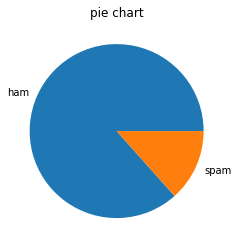

In [103]:
import matplotlib.pyplot as plt

count=df['label'].value_counts()
count.plot(kind = 'pie')
plt.title('pie chart')
plt.ylabel('')
plt.show();
#portion of text messages actually spam

Feature engineering
---------
lets see if the text length and the percentage of special characters might be useful for identifying spam messages

In [104]:
def punct(txt):
    count = sum([1 for char in txt if char in string.punctuation])
    #counting punctuations
    textlen=(len(txt) - txt.count(" "))
    #counting text length 
    return round(count/textlen, 3)*100
    #percentage of punctuation in text

df['text_len'] = df['text'].apply(lambda x: len(x) - x.count(" "))
df['punct_percent'] = df['text'].apply(lambda x: punct(x))


In [105]:
df.head()

,label,text,text_len,punct_percent
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8
1,ham,Ok lar... Joking wif u oni...,24,25.0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7
3,ham,U dun say so early hor... U c already then say...,39,15.4
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1


<Figure size 720x576 with 0 Axes>

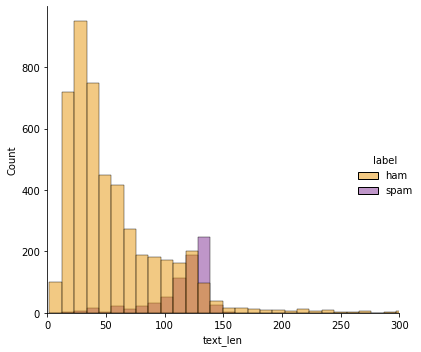

In [106]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(10,8))
sns.displot(df,x="text_len",hue="label",palette='CMRmap_r',bins=70)
plt.xlim(0,300)
plt.tight_layout()

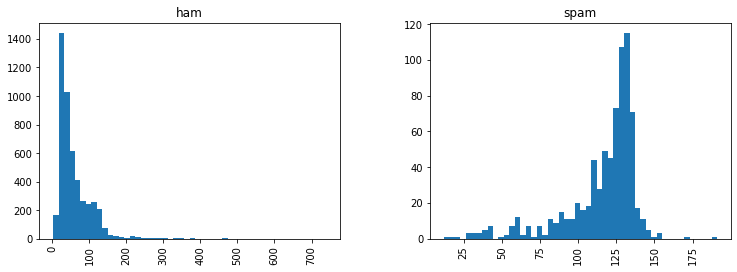

In [107]:
bins = np.linspace(0, 200, 40)
df.hist(column='text_len', by='label', bins=50,figsize=(12,4))
plt.show()

From the above plots its clear that spam messages are of more length and text_len emerged as an important feature for identifying spam messages

(0.0, 60.0)

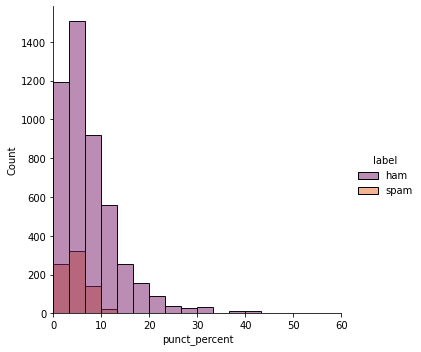

In [108]:
%matplotlib inline
sns.displot(df,x="punct_percent",hue="label",palette='inferno',bins=30)
plt.xlim(0,60)

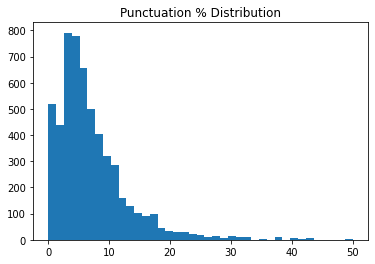

In [109]:
bins = np.linspace(0, 50, 40)

plt.hist(df['punct_percent'], bins)
plt.title("Punctuation % Distribution")
plt.show()

In [110]:
import numpy as np
df['label']=np.where(df['label']=='spam',1,0)

Preprocessing the text
=========

In [111]:
df['text'][8:15]

8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
10    I'm gonna be home soon and i don't want to tal...
11    SIX chances to win CASH! From 100 to 20,000 po...
12    URGENT! You have won a 1 week FREE membership ...
13    I've been searching for the right words to tha...
14                  I HAVE A DATE ON SUNDAY WITH WILL!!
Name: text, dtype: object

we can clearly see that the text is containig punctuations ,lets dive into data cleaning

In [112]:
lemma = nltk.WordNetLemmatizer()

In [113]:
def cleaning_text(text):
   #removing punctuations
   text="".join([word.lower() for word in text if word not in string.punctuation])
   # tokenizing data
   tokens=re.split('\W+',text)
   #removal of stopwords from the tokenixed text
   text=[lemma.lemmatize(word) for word in tokens if word not in stopwords]
   return text

In [114]:
stopwords=nltk.corpus.stopwords.words('english')

In [115]:
import nltk
nltk.download('wordnet')
df['clean_text'] = df['text'].apply(lambda x: cleaning_text(x))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,label,text,text_len,punct_percent,clean_text
0,0,"Go until jurong point, crazy.. Available only ...",92,9.8,"[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,24,25.0,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,39,15.4,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",49,4.1,"[nah, dont, think, go, usf, life, around, though]"


In [116]:
from sklearn.model_selection import train_test_split

In [117]:
#splitting our data into train and text
X_train, X_test, y_train, y_test = train_test_split(df.drop('label',axis=1),df['label'], test_size=0.2)

Vectorizing text using TF-IDF
===============

In [118]:
tfidf_vect = TfidfVectorizer(analyzer=cleaning_text)
train_vect=tfidf_vect.fit_transform(X_train['text'])
test_vect = tfidf_vect.transform(X_test['text'])

In [ ]:
train_vect.shape

(4457, 7813)

In [ ]:
tfidf_train = pd.DataFrame(train_vect.toarray())
tfidf_train.columns = tfidf_vect.get_feature_names()
tfidf_test = pd.DataFrame(test_vect.toarray())
tfidf_test.columns = tfidf_vect.get_feature_names()
print(tfidf_train.shape)
print(tfidf_test.shape)

(4457, 7813)
(1115, 7813)


In [ ]:
dff=pd.DataFrame(X_train['text_len'])
dgg=pd.DataFrame(X_train['punct_percent'])

In [ ]:
dss=pd.DataFrame(X_test['text_len'])
dqq=pd.DataFrame(X_test['punct_percent'])

In [ ]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
train_feat= hstack((tfidf_train,dff,dgg))
test_feat=hstack((tfidf_test,dss,dqq))
print(train_feat.shape)
print(test_feat.shape)

(4457, 7815)
(1115, 7815)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(train_feat, y_train)

In [ ]:
y_pred = rf_model.predict(test_feat)

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 1.0 / Recall: 0.827 / Accuracy: 0.978


VERCTORIZING TEXT USING WORD2VEC
-------------------

In [ ]:
import gensim
w2v_model = gensim.models.Word2Vec(X_train['clean_text'],
                                   size=100,
                                   window=5,
                                   min_count=2)
# Train a basic word2vec model on our training data

In [ ]:
words = set(w2v_model.wv.index2word)

In [ ]:
from tqdm import tqdm
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_text']): # for each review/sentence
    vector = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        if word in words:
            vector += w2v_model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

  0%|          | 0/4457 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
100%|██████████| 4457/4457 [00:00<00:00, 11669.57it/s]

4457
100


In [ ]:
from tqdm import tqdm
test_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_text']): # for each review/sentence
    vector = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        if word in words:
            vector += w2v_model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_w2v_vectors.append(vector)


  0%|          | 0/1115 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
100%|██████████| 1115/1115 [00:00<00:00, 7004.72it/s]


In [ ]:
print(len(test_w2v_vectors))
print(len(test_w2v_vectors[0]))

1115
100


In [ ]:
#lets stack numeric aand text features
train_w2v= hstack((avg_w2v_vectors,dff,dgg))
test_w2v=hstack((test_w2v_vectors,dss,dqq))
print(train_w2v.shape)
print(test_w2v.shape)


(4457, 102)
(1115, 102)


In [ ]:
rf = RandomForestClassifier()
rf_model = rf.fit(train_w2v, y_train)

In [ ]:
#model prediction and evaluation on test set
y_pred = rf_model.predict(test_w2v) 
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 1.0 / Recall: 0.691 / Accuracy: 0.961


Vectorization using DOC2VEC
=========

In [ ]:
#getting words usind DOC2VEC
doc_tag_train = [gensim.models.doc2vec.TaggedDocument(v, [i])
                     for i, v in enumerate(X_train['clean_text'])]
doc_tag_test = [gensim.models.doc2vec.TaggedDocument(v, [i])
                    for i, v in enumerate(X_test['clean_text'])]

In [ ]:
doc_tag_train[:10]

[TaggedDocument(words=['omw', 'back', 'tampa', 'west', 'palm', 'hear', 'happened'], tags=[0]),
 TaggedDocument(words=['pure', 'hearted', 'person', 'wonderful', 'smile', 'make', 'even', 'hisher', 'enemy', 'feel', 'guilty', 'enemy', 'catch', 'world', 'smile', 'goodmorning', 'amp', 'smiley', 'sunday'], tags=[1]),
 TaggedDocument(words=['recpt', '13', 'ordered', 'ringtone', 'order', 'processed'], tags=[2]),
 TaggedDocument(words=['ok', 'april', 'cant', 'wait'], tags=[3]),
 TaggedDocument(words=['ya', 'ok', 'dinner'], tags=[4]),
 TaggedDocument(words=['consider', 'wall', 'bunker', 'shit', 'important', 'never', 'play', 'peaceful', 'guess', 'place', 'high', 'enough', 'dont', 'matter'], tags=[5]),
 TaggedDocument(words=['sure', 'night', 'menu', 'know', 'noon', 'menu'], tags=[6]),
 TaggedDocument(words=['someone', 'u', 'know', 'asked', 'dating', 'service', '2', 'contact', 'cant', 'guess', 'call', '09058091854', 'revealed', 'po', 'box385', 'm6', '6wu'], tags=[7]),
 TaggedDocument(words=['callsme

In [ ]:
d2v_model = gensim.models.Doc2Vec(doc_tag_train,
                                  vector_size=100,
                                  window=5,
                                  min_count=2)
# Training a basic doc2vec model

In [ ]:
d2v_model.infer_vector(['happy', 'deepavali', 'to', 'everyone'])
#example to see how d2v vectors look like

array([ 2.50690710e-03, -1.48047535e-02, -7.04272278e-03, -6.83367485e-03,
        2.22320762e-03,  7.95769412e-03,  2.40248279e-03,  5.61994128e-03,
       -6.94849482e-03,  2.21587182e-03,  9.69665218e-03, -7.47682585e-04,
       -8.38195160e-03,  3.77993286e-03,  2.37473124e-03,  3.40466481e-03,
        1.12460693e-02, -1.95820280e-03, -1.47327119e-02, -9.97993909e-03,
        1.61639787e-03, -9.83112841e-04,  1.74994243e-03, -1.05431754e-05,
       -9.99938138e-03,  1.25824036e-02,  1.13125984e-02,  1.06225237e-02,
       -1.18393479e-02,  1.00579225e-02,  5.54088643e-03, -7.88440183e-03,
       -4.85946424e-03,  1.16722926e-03, -5.48183126e-03,  1.90768912e-02,
       -2.68416409e-03,  6.02410734e-03,  9.82735027e-03,  9.06077679e-03,
        1.04715605e-03,  1.75151974e-03,  7.35337613e-04, -1.01058381e-02,
        1.23227686e-02,  7.22568668e-03, -3.17909825e-03,  1.39575843e-02,
       -1.19969165e-02,  3.40859126e-03,  1.10997027e-02, -1.99971627e-03,
        4.96758195e-03,  

In [ ]:
#obtaning vectors using d2v for train and test data
train_vectors_final = [d2v_model.infer_vector (v.words) for v in doc_tag_train]
test_vectors_final = [d2v_model.infer_vector (v.words) for v in doc_tag_test]   

In [ ]:
#stack numerical and text features 
train_d2v= hstack((train_vectors_final,dff,dgg))
test_d2v=hstack((test_vectors_final,dss,dqq))
print(train_d2v.shape)
print(test_d2v.shape)

(4457, 102)
(1115, 102)


In [ ]:
#instantiate the random forest classifier
rf = RandomForestClassifier()
rf_model = rf.fit(train_d2v, y_train)
#predict model performance using test vectors
y_pred = rf_model.predict(test_d2v)
#evaluate the models performance
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} //// Recall: {} //// Accuracy: {}'.format(
    round(precision,2), round(recall, 2), round((y_pred==y_test).sum()/len(y_pred), 2)))

Precision: 0.81 //// Recall: 0.27 //// Accuracy: 0.9


Recurrent neural network 
=========

In [ ]:
# training the tokenizer and use tokenizer to convert the sentences to sequences of numbers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])

In [ ]:
train_seq_padded = pad_sequences(X_train_seq, 50)
test_seq_padded = pad_sequences(X_test_seq, 50)
# padding the sequences so each sequence is of same length

In [ ]:
train_rnn= hstack((train_seq_padded,dff,dgg))
test_rnn=hstack((test_seq_padded,dss,dqq))

print(train_rnn.shape)
print(test_rnn.shape)

(4457, 52)
(1115, 52)


In [ ]:
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

In [ ]:
#instantiating our neural network model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          250048    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 259,457
Trainable params: 259,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import keras
train_data=train_rnn.toarray()
test_data=test_rnn.toarray()

In [ ]:
train_seq_padded

array([[   0,    0,    0, ..., 3492,  291,  554],
       [   0,    0,    0, ...,   97, 3496,  927],
       [   0,    0,    0, ...,  351,  524, 2227],
       ...,
       [   0,    0,    0, ..., 1575,  559,  310],
       [   0,    0,    0, ...,  479,   28,   77],
       [   0,    0,    0, ...,   97, 1829,    1]], dtype=int32)

In [ ]:
#compiling our rnn model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

In [ ]:
#fitting our model to our train data and evaluating on test data for each epoch
history = model.fit(train_data,
                    y_train,
                    batch_size=32, 
                    epochs=10,
                    validation_data=(test_data, y_test))

Epoch 1/10
140/140 [==============================] - 4s 27ms/step - loss: 1.1528e-05 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 0.1387 - val_accuracy: 0.9848 - val_precision_3: 0.9919 - val_recall_3: 0.8849
Epoch 2/10
140/140 [==============================] - 4s 25ms/step - loss: 9.9789e-06 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 0.1403 - val_accuracy: 0.9848 - val_precision_3: 0.9919 - val_recall_3: 0.8849
Epoch 3/10
140/140 [==============================] - 4s 26ms/step - loss: 8.7129e-06 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 0.1419 - val_accuracy: 0.9848 - val_precision_3: 0.9919 - val_recall_3: 0.8849
Epoch 4/10
140/140 [==============================] - 4s 26ms/step - loss: 7.6621e-06 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 0.1433 - val_accuracy: 0.9848 - val_precision_3: 0.9919 - val_recall_3: 0.8849
Epoch 5/10
140/140 [==============================] 

Summarizing All models performace 

In [56]:
from prettytable import PrettyTable


In [57]:
myTable = PrettyTable(["model", "Accuracy ", "Precision           ","Recall           "])

In [58]:
#x.add_column("TFIDF","WORD2VEC","DOC2VEC","RNN",[model])
myTable.add_row(["TFIDF", "97 %", "1.0", "0.82"]) 
myTable.add_row(["WORD2VEC", "96.1 %", "1.0", "0.69"]) 
myTable.add_row(["DOC2VEC", "90 %", "0.81", "0.27"]) 
myTable.add_row(["RNN", "98 %", "0.99", "0.88"]) 


In [59]:
print(myTable)

+----------+-----------+----------------------+-------------------+
|  model   | Accuracy  | Precision            | Recall            |
+----------+-----------+----------------------+-------------------+
|  TFIDF   |    97 %   |         1.0          |        0.82       |
| WORD2VEC |   96.1 %  |         1.0          |        0.69       |
| DOC2VEC  |    90 %   |         0.81         |        0.27       |
|   RNN    |    98 %   |         0.99         |        0.88       |
+----------+-----------+----------------------+-------------------+


Summary
-------------
We can clearly see that our basic RNN model performs better than TFIDF,W2V,D2V models.
we can further tune the hyper parameters and experiment on TFIDF,W2V,D2V which might increase the models performance.